# Metric Analysis - Part:1

### Overview
The purpose of this notebook is explore various facets of any metric like 
- What is its average, minimum, maximum & frequent values of the metric under consideration?.
- What is the shape and personality of the metric? 
- How many distinct workload (ex: bootstrom etc) profiles in this metric? 
- What is this range and variation of this metric? tight, wide etc.
- What is the trend, seasonality and noise embedded in this metric?
- Is it flat, up or down trend? What is the persistency?
- When and how often the recurring cycles (ex: bootstorm) happen? 
- How many varieties of recurring cycles?
- How does this metric behave by hour of the day? by day of the week? etc..

Broadly we have 3 types of Analytics -

1. **Descriptive Analytics**
2. **Predictive Analytics**
3. **Prescriptive Analytics**

In this notebook, we focus on the **Descriptive Analytics** part. The other two are for future notebooks.

### Style Settings

In [15]:
%matplotlib inline

# CSS File
from IPython.core.display import HTML
from IPython.display import Image

# Libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime as dt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

#from cogent.maths.period import dft, auto_corr

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [16]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### Libraries

In [17]:
def read_metric_data(metric_name, csv_name):
    '''
        Read metric data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
        
    #print("{0} - #Observations: {1}".format(csv_name, df.shape))
    return df

def describe_metric(metric_name, df):
    '''
        Generate custom summary of the data
    '''
    summary = df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95])
    summary.columns = [metric_name]
    summary = summary.applymap('{:.2f}'.format) # URL: https://pyformat.info/
    #summary['value'] = summary['value'].map('{:.2f}'.format) 
    #summary.drop(labels=['count'], axis=0, inplace=True)
    summary.loc['frequent'] = df.mode().value[0]
    summary.loc['skewness'] = df.value.skew()
    summary.loc['kurtosis'] = "{0:.2f}".format(round(df.value.kurtosis(), 2))
    summary = summary.rename(index={'count': 'samples', 'mean':'average', 'std':'std dev', 'min':'lowest', 'max':'highest'})
    return summary

def decompose_ts(df, period=24, min_ev=0.05):
    # Detrend and Deseasonalize
    seasons, trend = fit_seasons(df.value, period=period, min_ev=min_ev)
    adjusted = adjust_seasons(df.value, period=period, seasons=seasons)
    residual = adjusted - trend
    return (seasons, trend, adjusted, residual)

In [18]:
def create_line_plot(metric_name, series):
    '''
        Create line plot using seaborn
    '''
    # Create line chart
    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(metric_name + ' Chart', fontsize=12, fontweight='bold')
    ax = plt.gca()
    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d %I:%M %p')) # TimeFormat : http://strftime.org/
    plt.plot(series, color='steelblue')
    #plt.xlabel("timestamp", fontweight='bold')
    plt.ylabel(metric_name)
    plt.gcf().autofmt_xdate()
    return

def create_summary_plot(metric_name, summary):
    summary = summary.copy()
    summary = summary.T
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle('Summary', fontsize=12, fontweight='bold', verticalalignment='baseline')
    g = sns.barplot(data=summary, color='steelblue')
    g.set_ylabel(metric_name, fontsize=12)
    return

def create_shape_plots():
    df1 = read_metric_data("Disk_Utilization", "data/du_7d.txt")
    df2 = read_metric_data("write_bytes_per_sec", "data/wbs_7d.txt")
    df3 = read_metric_data("read_bytes_per_sec", "data/rbs_7d.txt")

    composite = pd.concat([df1.value, df2.value, df3.value], axis=1, join_axes=[df1.index])
    composite.columns = ["Disk_Utilization", "Write_Bytes_Sec", "Read_Bytes_Sec"]
    composite.index.name = "timestamp"
    composite.head()
    
    #Distribution Plot
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
    fig.suptitle('Workload Shapes', fontsize=12, fontweight='bold', verticalalignment='baseline')
    
    sns.set_palette(sns.color_palette("muted"))
    #fig.subplots_adjust(hspace=.5)
    fig.tight_layout()
   
    g1 = sns.kdeplot(df1.value, shade=True, ax=ax1);
    g1.set_xlabel(composite.columns[0], fontsize=12)
    g2 = sns.kdeplot(df2.value, shade=True, ax=ax2);
    g2.set_xlabel(composite.columns[1], fontsize=12)
    g3 = sns.kdeplot(df3.value, shade=True, ax=ax3);
    g3.set_xlabel(composite.columns[2], fontsize=12)
    
    #Violin Plots
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
    fig.subplots_adjust(hspace=.5)
    fig.tight_layout()
    
    g1 = sns.violinplot(data=composite.Disk_Utilization, ax=ax1)
    g1.set_xlabel(composite.columns[0], fontsize=12)
    g2 = sns.violinplot(data=composite.Write_Bytes_Sec, ax=ax2)
    g2.set_xlabel(composite.columns[1], fontsize=12)
    g3 =sns.violinplot(data=composite.Read_Bytes_Sec, ax=ax3)
    g3.set_xlabel(composite.columns[2], fontsize=12)
    return

def create_acf_plots(metric, y, lags=None):
    fig = plt.figure(figsize=(10,6))
    fig.suptitle('Cycles & Auto Correlations', fontsize=12, fontweight='bold', verticalalignment='baseline')
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    ts_ax.set_ylabel(metric)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

def create_decomposition_plots(metric_name, period, df):
    (seasons, trend, adjusted, residual) = decompose_ts(df, period=period, min_ev=0.01)
    
    sns.set_palette(sns.color_palette("muted"))
    f, axarr = plt.subplots(4, figsize=(12, 12))
    f.subplots_adjust(hspace=.5)
    #f.suptitle('Metric Decomposition', fontsize=12, fontweight='bold', verticalalignment='bottom')

    axarr[0].plot(df.value)
    axarr[0].set_title(metric_name + '   (Observed)')

    #axarr[1].plot(adjusted)
    #axarr[1].set_title(metric_name +'    (without cycles)')

    axarr[1].plot(residual)
    axarr[1].set_title(metric_name + '   (Noise)')

    axarr[2].plot(pd.Series(fit_trend(df.value)))
    axarr[2].set_title(metric_name + '   (Trend)')

    axarr[3].plot(seasons)
    axarr[3].set_title(metric_name + '   (Seasonality)')
    axarr[3].set_autoscalex_on(False)
    axarr[3].xaxis.set_major_locator(ticker.MultipleLocator(2))
    return

def create_boxplot(metric_name, df):
    fig = plt.figure(figsize=(12,1))
    fig.suptitle('Overall Behavior', fontsize=12, fontweight='bold', verticalalignment='baseline')
    g1 = sns.boxplot(y=df.value, linewidth=2, color='lightsteelblue', orient='h')
    g1.set_xlabel(metric_name, fontsize=12)
    return

def create_boxplot_by_hourofday(metric_name, df):
    df = df.copy()
    df['H'] = df.index.hour
    df['Hour'] = df.index.strftime('%I:%M %p')
    df.sort_values(by='H', axis=0, ascending=True, inplace=True)
    fig = plt.figure(figsize=(12,4))
    fig.suptitle('Behavior (By Hour of Day)', fontsize=12, fontweight='bold', verticalalignment='baseline')
    ax = sns.boxplot(x='Hour', y="value", data=df, color='lightsteelblue')
    ax.set_ylabel(metric_name)
    plt.gcf().autofmt_xdate()
    return ax

def create_boxplot_by_dayofweek(metric_name, df):
    df = df.copy()
    df['D'] = df.index.dayofweek
    df['Day'] = df.index.strftime('%a')
    df.sort_values(by='D', axis=0, ascending=True, inplace=True)
    fig = plt.figure(figsize=(12,4))
    fig.suptitle('Behavior (By Day of Week)', fontsize=12, fontweight='bold', verticalalignment='baseline')
    ax = sns.boxplot(x='Day', y="value", data=df, color='lightsteelblue')
    ax.set_ylabel(metric_name)
    plt.gcf().autofmt_xdate()
    return ax

### Configuration

In [19]:
metric_name = "Disk Utilization (%)"
csv_name = 'data/du_7d.txt'

print("metric_name:\t{0}, \ndata_filename:\t{1}".format(metric_name, csv_name))

metric_name:	Disk Utilization (%), 
data_filename:	data/du_7d.txt


### Visual Analysis

In [20]:
# Load data
df1 = read_metric_data(metric_name, csv_name)
df1.value = df1.value.round(3)

# Print Input Data Sample
df = df1.copy()
df['value'] = df['value'].map('{:.2f}'.format) 

In [21]:
# Create Summary
summary = describe_metric(metric_name, df1)
summary.T

,samples,average,std dev,lowest,5%,25%,50%,75%,95%,highest,frequent,skewness,kurtosis
Disk Utilization (%),168.00,0.11,0.01,0.10,0.10,0.11,0.11,0.11,0.13,0.16,0.107,3.01926,10.34


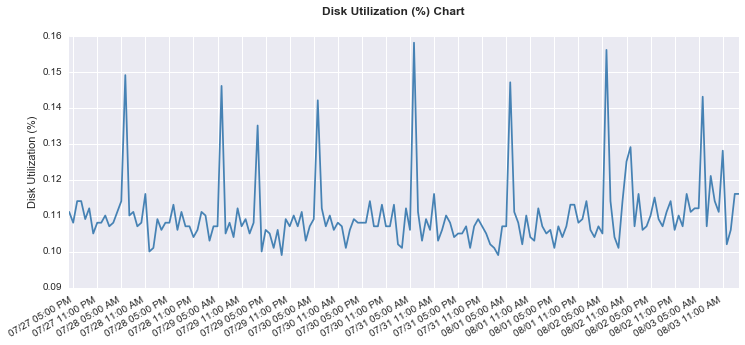

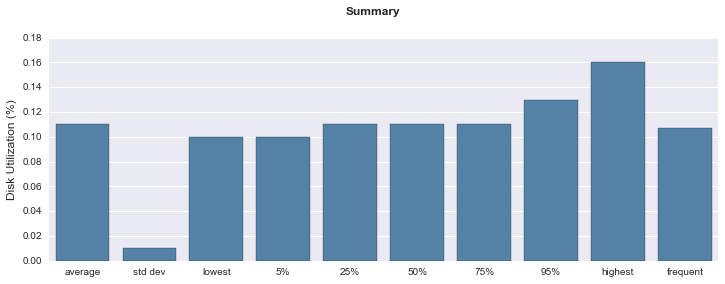

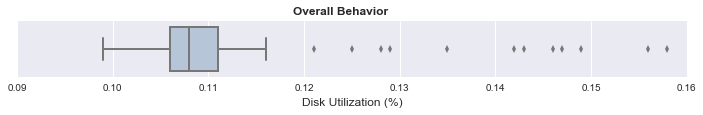

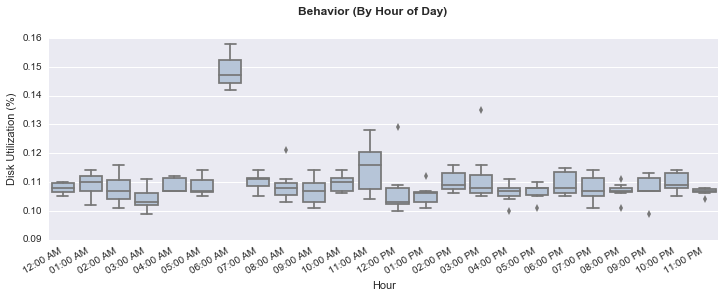

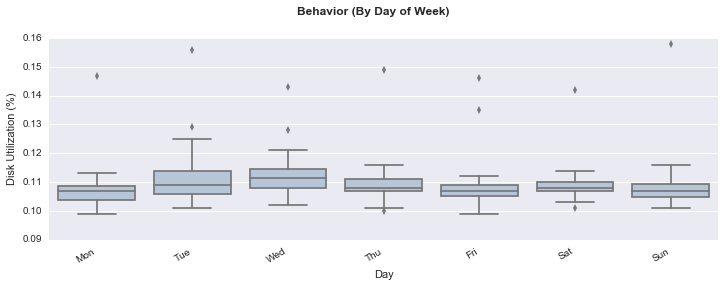

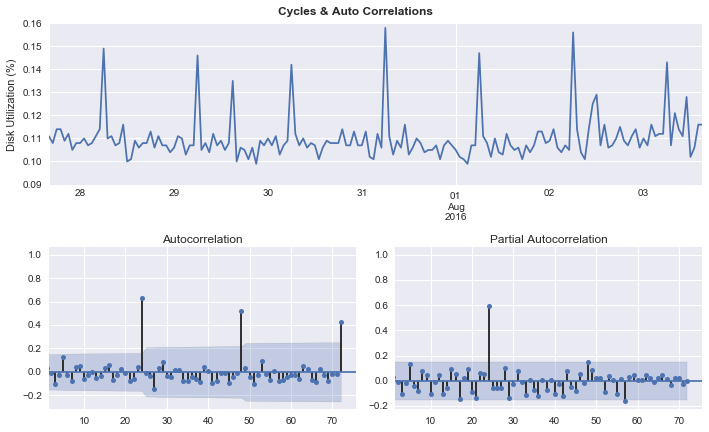

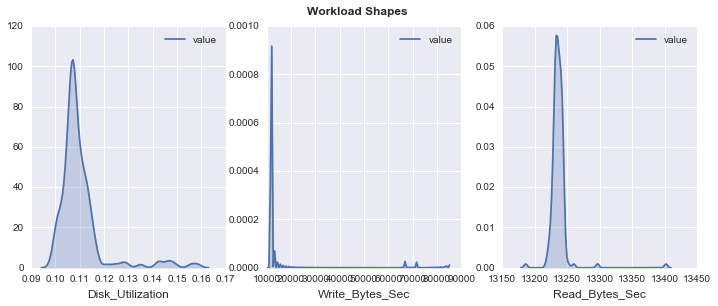

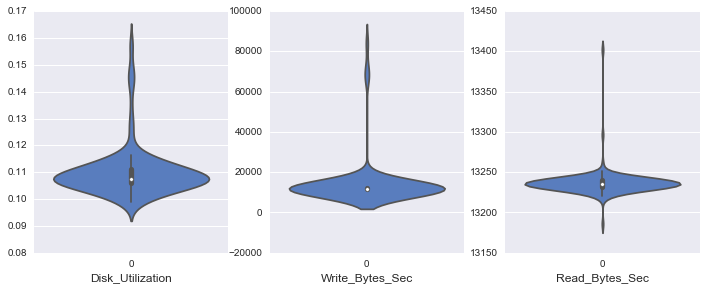

In [22]:
# Create Line Plot
create_line_plot(metric_name, df1.value)

# Create Summary Plot
create_summary_plot(metric_name, summary.iloc[1:-2]) #drop 1 row and last 2 rows.

# Create Behavior Plot (HOD, DOW, WOY) plots
create_boxplot(metric_name, df1)
create_boxplot_by_hourofday(metric_name, df1)
create_boxplot_by_dayofweek(metric_name, df1)

# Create Cycle Plots
axarr = create_acf_plots(metric_name, y=df1.value, lags=72)

# Create Shapes
create_shape_plots()

### Decomposition  Analysis

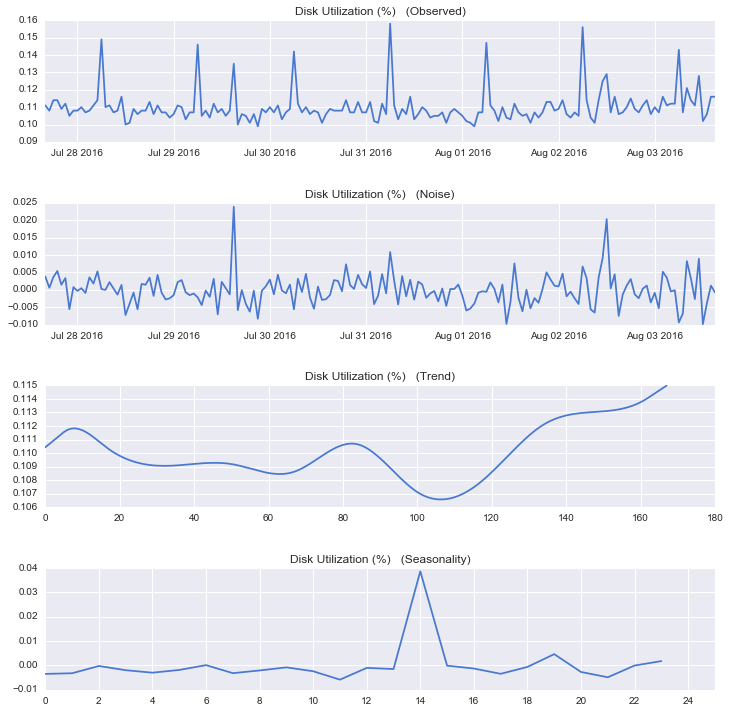

In [23]:
# Decompose time series. Create Decomposition Plots
(seasons, trend, adjusted, noise) = decompose_ts(df1)
create_decomposition_plots(metric_name=metric_name, period=24, df=df1)
#axarr = create_acf_plots('noise', y=noise, lags=72)